## Introduction
This file is concerned with the second asssignment in the ST 443 group project. The task is on a high-dimensional binary classification problem using neural spike-count data recorded from the mouse frontal cortex during a decision-making task. Each trial contains spike activity from 2238 neurons across 5 time bins, resulting in 11,190 features, while the dataset includes only 683 trials. Hence we need to have minimal number of features to avoid p>n. We will start with T2.1, which is concerned with data visualization and understanding the distribution of the features, and the target.

## Data Preparation and Imports

### Import

In [675]:
# Load the dataset
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["XGB_GLOBAL_SEED"] = "42"
np.random.seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC



### Read the csv file

In [676]:
data2 = pd.read_csv("data-2.csv.gz") # Data already in local directory, don't worry about absolute paths
input = data2.drop(columns=["label"])
target = data2["label"]

## Task 2.1: EDA

Inspect the dataset

In [677]:
#Shape of the dataframe
print(f"\n Number of Rows: {data2.shape[0]} \n Number of Columns: {data2.shape[1]}")
# 11900 features + 1 target


 Number of Rows: 683 
 Number of Columns: 11191


In [678]:
#Datatypes of all the columns in the dataset
data2.dtypes

label              int64
unit_0000_bin_0    int64
unit_0001_bin_0    int64
unit_0002_bin_0    int64
unit_0003_bin_0    int64
                   ...  
unit_2233_bin_4    int64
unit_2234_bin_4    int64
unit_2235_bin_4    int64
unit_2236_bin_4    int64
unit_2237_bin_4    int64
Length: 11191, dtype: object

In [679]:
#Information about the dataset
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Columns: 11191 entries, label to unit_2237_bin_4
dtypes: int64(11191)
memory usage: 58.3 MB


In [680]:
#Look at the first 5 entries
data2.head()

,label,unit_0000_bin_0,unit_0001_bin_0,unit_0002_bin_0,unit_0003_bin_0,unit_0004_bin_0,unit_0005_bin_0,unit_0006_bin_0,unit_0007_bin_0,unit_0008_bin_0,...,unit_2228_bin_4,unit_2229_bin_4,unit_2230_bin_4,unit_2231_bin_4,unit_2232_bin_4,unit_2233_bin_4,unit_2234_bin_4,unit_2235_bin_4,unit_2236_bin_4,unit_2237_bin_4
0,1,1,0,0,2,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4,8,0,3,9,13,6,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,5,0,2,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,8,0,0,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,1,3,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Summary statistics

In [681]:
#Summary statistics of the float columns
data2.select_dtypes(include="number").describe()

,label,unit_0000_bin_0,unit_0001_bin_0,unit_0002_bin_0,unit_0003_bin_0,unit_0004_bin_0,unit_0005_bin_0,unit_0006_bin_0,unit_0007_bin_0,unit_0008_bin_0,...,unit_2228_bin_4,unit_2229_bin_4,unit_2230_bin_4,unit_2231_bin_4,unit_2232_bin_4,unit_2233_bin_4,unit_2234_bin_4,unit_2235_bin_4,unit_2236_bin_4,unit_2237_bin_4
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.0,...,683.0,683.000000,683.000000,683.0,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,0.695461,1.512445,2.991215,0.237189,0.756955,1.286969,1.446559,0.931186,1.070278,0.0,...,0.0,0.127379,0.067350,0.0,0.207906,0.004392,0.029283,0.089312,0.001464,0.035139
std,0.460549,1.368178,1.935904,0.660551,1.239415,2.622303,3.198882,1.541111,1.504941,0.0,...,0.0,0.459373,0.278512,0.0,0.601169,0.066178,0.246424,0.449098,0.038264,0.245656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,7.000000,10.000000,5.000000,9.000000,15.000000,19.000000,9.000000,11.000000,0.0,...,0.0,4.000000,2.000000,0.0,5.000000,1.000000,3.000000,4.000000,1.000000,3.000000


Missing values

In [682]:
#Missing values
print("Missing values", data2.isnull().any().any())

Missing values False


Duplicates

In [683]:
#Duplicates check
print("Duplicates", data2[data2.duplicated() == True])

Duplicates Empty DataFrame
Columns: [label, unit_0000_bin_0, unit_0001_bin_0, unit_0002_bin_0, unit_0003_bin_0, unit_0004_bin_0, unit_0005_bin_0, unit_0006_bin_0, unit_0007_bin_0, unit_0008_bin_0, unit_0009_bin_0, unit_0010_bin_0, unit_0011_bin_0, unit_0012_bin_0, unit_0013_bin_0, unit_0014_bin_0, unit_0015_bin_0, unit_0016_bin_0, unit_0017_bin_0, unit_0018_bin_0, unit_0019_bin_0, unit_0020_bin_0, unit_0021_bin_0, unit_0022_bin_0, unit_0023_bin_0, unit_0024_bin_0, unit_0025_bin_0, unit_0026_bin_0, unit_0027_bin_0, unit_0028_bin_0, unit_0029_bin_0, unit_0030_bin_0, unit_0031_bin_0, unit_0032_bin_0, unit_0033_bin_0, unit_0034_bin_0, unit_0035_bin_0, unit_0036_bin_0, unit_0037_bin_0, unit_0038_bin_0, unit_0039_bin_0, unit_0040_bin_0, unit_0041_bin_0, unit_0042_bin_0, unit_0043_bin_0, unit_0044_bin_0, unit_0045_bin_0, unit_0046_bin_0, unit_0047_bin_0, unit_0048_bin_0, unit_0049_bin_0, unit_0050_bin_0, unit_0051_bin_0, unit_0052_bin_0, unit_0053_bin_0, unit_0054_bin_0, unit_0055_bin_0, unit

Invalid/out-of-range values

In [684]:
negative_values = (input < 0).sum().sum()
print("Total negative spike counts:", negative_values)
non_integer_values = ((input % 1) != 0).sum().sum()
print("Total non-integer entries:", non_integer_values)
max_value = input.max().max()
print("Maximum spike count observed:", max_value)

Total negative spike counts: 0
Total non-integer entries: 0
Maximum spike count observed: 29


Outlier detection

This dataset is clearly non-normal, as the entries are all integers, rather Poisson-like structure, so we don't use z-score method

In [685]:
# Neurons that never fire
feature_totals = input.sum(axis=0)
never_fire = feature_totals[feature_totals == 0]
print("Non-firing features:", len(never_fire))
# Out of 11,190 neuron–time-bin features, 536 features never fired
# Don't remove them as they don't harm, some neurons may just act like this: do not fire during a particular time window.

# IQR method
trial_totals = input.sum(axis=1)

q1, q3 = trial_totals.quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 3*iqr, q3 + 3*iqr   # 3×IQR stricter than 1.5×IQR

trial_outliers = trial_totals[(trial_totals < lower) | (trial_totals > upper)]
print("Abnormal trials:", len(trial_outliers))


Non-firing features: 536
Abnormal trials: 0


Distribution of target: label column

<Axes: xlabel='label'>

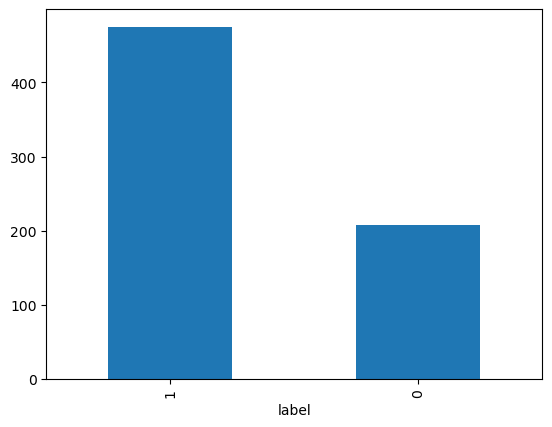

In [686]:
data2['label'].value_counts().plot(kind='bar')

Sample distribution of features

array([[<Axes: title={'center': 'unit_1027_bin_4'}>,
        <Axes: title={'center': 'unit_2095_bin_1'}>,
        <Axes: title={'center': 'unit_1196_bin_3'}>],
       [<Axes: title={'center': 'unit_2157_bin_1'}>,
        <Axes: title={'center': 'unit_0778_bin_1'}>,
        <Axes: title={'center': 'unit_0545_bin_4'}>],
       [<Axes: title={'center': 'unit_1740_bin_0'}>,
        <Axes: title={'center': 'unit_0634_bin_3'}>,
        <Axes: title={'center': 'unit_0734_bin_4'}>],
       [<Axes: title={'center': 'unit_0493_bin_4'}>,
        <Axes: title={'center': 'unit_1822_bin_2'}>,
        <Axes: title={'center': 'unit_0705_bin_2'}>]], dtype=object)

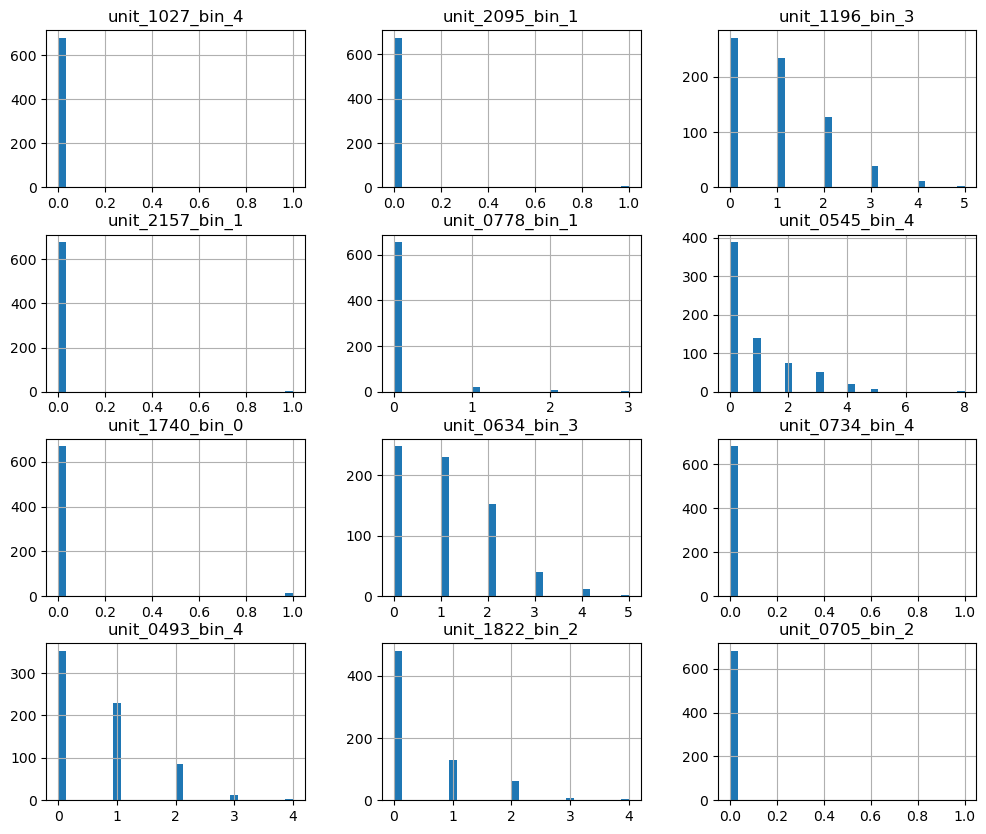

In [687]:
sample_cols = input.sample(12, axis=1)
sample_cols.hist(bins=30, figsize=(12,10))
# We can see many zeros and typically right-skewed distributions, implying that many features are uninformative
# Linear models (e.g., Logistic Regression) may struggle without regularisation, LASSO/Ridge are appropriate.
# Tree-based models may identify informative subsets automatically

Percentage of zeros (a more intuitive understanding of how prevailing the zeros are from above histo)

In [688]:
zero_prop = (input == 0).mean().mean()
print("Zero proportion:", zero_prop)

Zero proportion: 0.7403449272973018


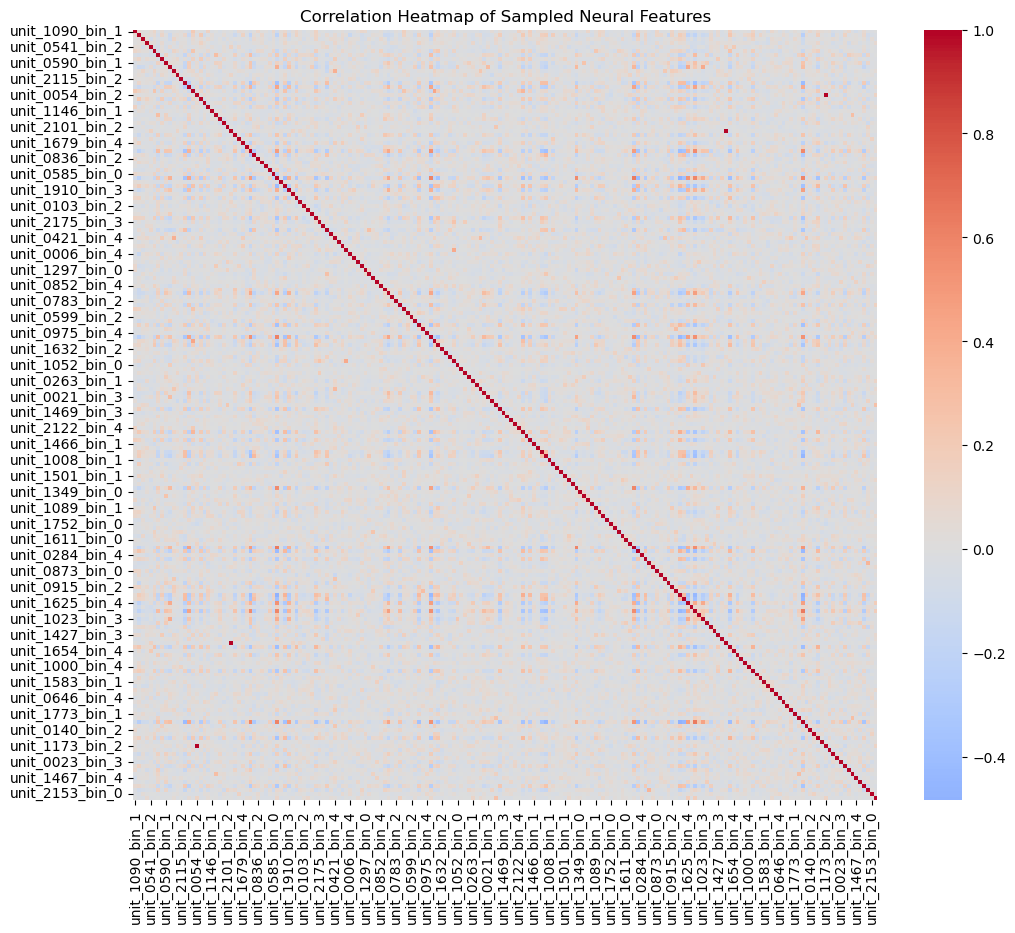

In [689]:
# Just routinely heatmap (select a subset of features for visibility)
# Sample a subset of features (e.g., 200)
subset = input.sample(200, axis=1)

# Remove constant columns (std = 0)
subset = subset.loc[:, subset.std(axis=0) > 0]

# Compute correlation
corr = subset.corr()

# Replace NaNs if any remain
corr = corr.replace([np.inf, -np.inf], np.nan).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Sampled Neural Features")
plt.show()
# VERY VERY low correlations between features, only a few pairs show moderate correlation (sparse colour blocks)

For now, we have strong evidence that a large amount of the features are redundant. Hence, we can consider, with confident, LASSO, tree models, and some other methods that helps with high-dimensionality (p>n) and feature selection

## Task 2.2 - Model Development

In this part of the tast, we will be fitting 3 covered selectors + 3 classifiers, with 1 new selector + 1 classifier, with the goal of maximising balanced accuracy.

**KEY LOGIC: (SECLECTOR) → (CLASSIFIER)**

### Define functions to evaluate performances

Create function to report cross-validation performance

In [690]:
def evaluate_cv(estimator, X, y, n_splits=5, random_state=42):
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    cv_results = cross_validate(
        estimator,
        X,
        y,
        cv=cv,
        scoring="balanced_accuracy",
        n_jobs=-1,
        return_train_score=False
    )

    test_scores = cv_results["test_score"]
    return test_scores.mean(), test_scores.std()

Function to evaluate the performance on the test set, and return the predictions

In [691]:
def predict_evaluate(estimator, X_train, X_test, y_train, y_test, model_name):
    
    # Fit
    estimator.fit(X_train, y_train)

    # Predict
    y_pred = estimator.predict(X_test)

    # Balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Performance DF
    df_performance = pd.DataFrame({
        "model": [model_name],
        "balanced_accuracy": [bal_acc]
    })

    # Predictions DF
    df_predictions = pd.DataFrame({
        "model": model_name,
        "y_true": y_test,
        "y_pred": y_pred
    })

    return df_performance, df_predictions, cm

Generalization of the previous function to test the performance of multiple models

In [692]:
def multiple_predict_evaluate(models, X_train, X_test, y_train, y_test):
    
    perf_list = []
    preds_list = []
    cms = {}

    for name, est in models:
        df_perf, df_pred, cm = predict_evaluate(
            est, X_train, X_test, y_train, y_test, name
        )
        perf_list.append(df_perf)
        preds_list.append(df_pred)
        cms[name] = cm

    df_performances = pd.concat(perf_list, ignore_index=True)
    df_predictions = pd.concat(preds_list, ignore_index=True)

    return df_performances, df_predictions, cms

Function to plot the confusion matrix

In [693]:
def plot_confusion_matrix(cm, class_names=None, normalize=True, title=None, figsize=(6,5)):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        xticklabels=class_names if class_names is not None else np.arange(cm.shape[1]),
        yticklabels=class_names if class_names is not None else np.arange(cm.shape[0]),
        cbar=True
    )

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

Count # features

In [694]:
def count_selected_features(fitted_estimator, X_fit):
    # Case 1: Pipeline with a selector step
    if hasattr(fitted_estimator, "named_steps"):
        for step_name, step in fitted_estimator.named_steps.items():
            if hasattr(step, "get_support"):
                support = step.get_support()
                return int(np.sum(support))

    # Case 2: bare selector
    if hasattr(fitted_estimator, "get_support"):
        support = fitted_estimator.get_support()
        return int(np.sum(support))

    # Fallback: no selector → all features
    return X_fit.shape[1]

### Preparations of the features and the target

Input and target were defined earlier in 2.1, so we go straight for data split

In [695]:
# General train/test split
X_train, X_test, y_train, y_test = train_test_split(
    input, 
    target, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=target #This ensures the train and test set follow the same distribution as the original dataset
)

In [696]:
print(f"\n Number of observations in the training set: {X_train.shape[0]}", f"\n Number of observations in the test set: {X_test.shape[0]}")


 Number of observations in the training set: 546 
 Number of observations in the test set: 137


In [697]:
X_train.head()

,unit_0000_bin_0,unit_0001_bin_0,unit_0002_bin_0,unit_0003_bin_0,unit_0004_bin_0,unit_0005_bin_0,unit_0006_bin_0,unit_0007_bin_0,unit_0008_bin_0,unit_0009_bin_0,...,unit_2228_bin_4,unit_2229_bin_4,unit_2230_bin_4,unit_2231_bin_4,unit_2232_bin_4,unit_2233_bin_4,unit_2234_bin_4,unit_2235_bin_4,unit_2236_bin_4,unit_2237_bin_4
465,4,1,0,3,0,0,4,2,0,2,...,0,0,0,0,0,0,0,0,0,0
230,2,3,0,2,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
355,5,3,0,2,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
317,1,4,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
167,3,4,1,1,12,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [698]:
y_train.head()

465    0
230    0
355    0
317    0
167    1
Name: label, dtype: int64

In [699]:
assert set(X_train.index).isdisjoint(set(X_test.index))

The universal classifier: Logistic Classifier

In [700]:
# We use logistic classifier as the consistent classifier across all selectors, to ensure fair comparisons between selectors
# Stable
clf = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=1000,
    n_jobs=1, # Deterministic, reinstates reproductivity
    random_state=42
)

Universal model-list template

In [701]:
def model_list(method_name: str, k_values, pipeline_builder):
    """
    Build a list of (name, pipeline) for a given feature-selection method.

    method_name     : short string, e.g. "MI", "RF"
    k_values        : list of complexity values (usually 'k' = #features)
    pipeline_builder: function taking k and returning a Pipeline
    """
    return [
        (f"{method_name}_k{k}", pipeline_builder(k))
        for k in k_values
    ]

\# of features k

In [702]:
k_values = [20, 50, 100, 200]

### Create pipelines to fit the selectors. 

In [703]:
# L1 selector (L1 selector + L2 in the classifier isn't redundant, the two penalty terms are in differnt stages)


# RF selector


# XGBoost selector


# Extra: MI selector
def mi_score(X, y): # This step tries to mitigate the randomness in MI. Refer to ur own model for randomness fix
    return mutual_info_classif(X, y, n_neighbors=10, random_state=42) # Defult n_neighbours=3, increase to stabilise density estimation for better performance

def mi_logistic_pipeline_builder(k: int):
    return Pipeline([
        ("scale", StandardScaler()),
        ("select", SelectKBest(score_func=mi_score, k=k)),
        ("clf", clf),
    ])

With our pre-defined pipelines, build one model per k

In [704]:
# L1 per k


# RF per k


# XGB per k


# MI per k
mi_models = model_list(
    method_name="MI",
    k_values=k_values,
    pipeline_builder=mi_logistic_pipeline_builder
)

### Evaluate methods

In [705]:
# L1 performance

In [706]:
# RF performance

In [707]:
# XGB performance

In [708]:
# MI performance
df_perf_mi, df_pred_mi, cms_mi = multiple_predict_evaluate(mi_models, X_train, X_test, y_train, y_test)
# Add number of selected features
n_features_mi = []
for name, est in mi_models:
    fitted = clone(est).fit(X_train, y_train)
    n_features_mi.append(count_selected_features(fitted, X_train))

df_perf_mi["n_features"] = n_features_mi
df_perf_mi
# Approx 1'40"

,model,balanced_accuracy,n_features
0,MI_k20,0.594110,20
1,MI_k50,0.639223,50
2,MI_k100,0.648622,100
3,MI_k200,0.688471,200


Confusion matrix for the best feature method

In [709]:
# Best L1

In [710]:
# Best RF

In [711]:
# Best XGB

Best MI model: MI_k200


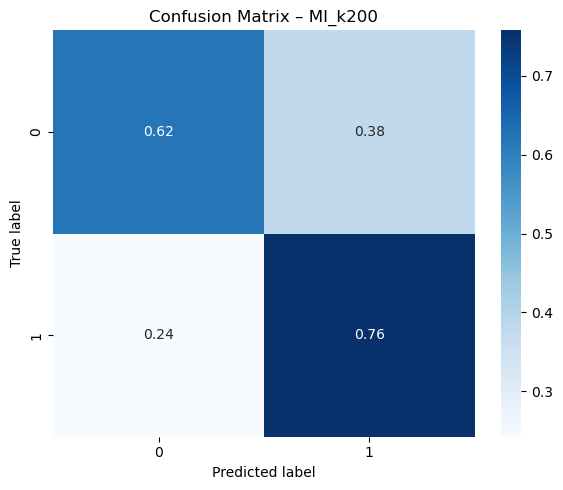

In [712]:
# Best MI
best_mi_row = df_perf_mi.sort_values("balanced_accuracy", ascending=False).iloc[0]
best_mi_name = best_mi_row["model"]
print("Best MI model:", best_mi_name)

cm_best_mi = cms_mi[best_mi_name]

plot_confusion_matrix(cm_best_mi,class_names=np.unique(target), normalize=True,title=f"Confusion Matrix – {best_mi_name}")

Combined plot to see method-wise performance

In [713]:
df_all = pd.concat([
    df_perf_mi.assign(method="MI"),
    #df_perf_rf.assign(method="RF"),
    #df_perf_l1.assign(method="L1"),
    #df_perf_xgb.assign(method="XGB"),
], ignore_index=True)

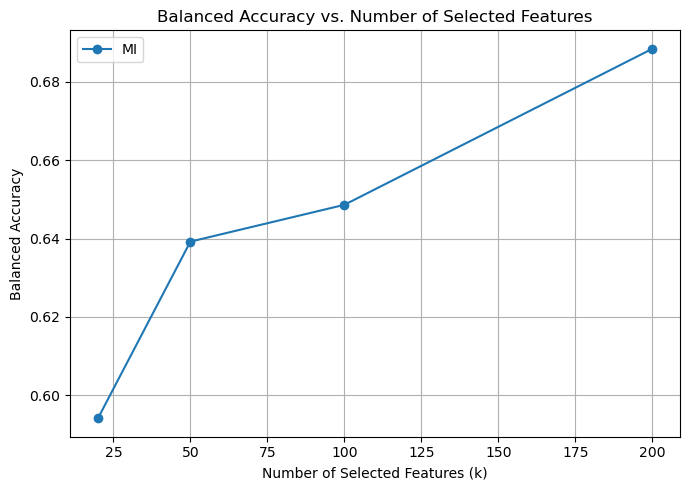

In [714]:
plt.figure(figsize=(7, 5))

for method in df_all["method"].unique():
    sub = df_all[df_all["method"] == method]
    plt.plot(
        sub["n_features"],
        sub["balanced_accuracy"],
        marker="o",
        label=method
    )

plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy vs. Number of Selected Features")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()